#### Cartpole
Code guided from:
* https://www.nature.com/articles/nature14236
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb
* https://github.com/openai/baselines/tree/master/baselines/deepq
* https://github.com/jasonbian97/Deep-Q-Learning-Atari-Pytorch



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm.notebook import tqdm
from collections import deque
import itertools
import random
import gym
from collections import namedtuple

import torch.nn as nn
import torch.nn.functional as F


import torchvision.transforms as T

### Hyperparamters

Based on 

https://www.nature.com/articles/nature14236 *Human-level control through deep reinforcement
learning*



In [2]:
gamma = 0.99                  # discount rate 
batch_size = 32               # batch size
memory_size = 50000           # mem capacity of our replay memory
required_mem = 1000           # init-size how much we want in the memory before training 
e_start = 1.0                 # start value of epsilon 
e_end =  0.02                 # end value of epsilon 
e_steps = 10000               # number of steps for epsilon reaches end
target_update = 1000          # how often we update target network to action network
lr = 25e-5                    # learning rate


#### Info about game
A reward of +1 is given for every time step the pole remains upright. An episode ends when: 

1) the pole is more than 15 degrees from vertical;

or 

2) the cart moves more than 2.4 units from the center


200 reward is max, after 200 game ends


Cartpole observation consits of (inorder):
* position of cart
* velocity of cart
* angle of pole
* rotation rate of pole

Cartpole actions consists of (inorder):
* Push cart to the left
* Push cart to the right



#### Replay Memory

In [3]:
class ReplayMemory():
    def __init__(self):
        self.replay_mem = deque(maxlen=memory_size)
        self.reward_eps_mem = deque([0.0], maxlen=100)
    def update_replay(self,experience):
        self.replay_mem.append(experience)
    
    def update_eps_reward(self,reward):
        self.reward_eps_mem.append(reward)
        

#### Network

In [4]:
class LinModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self,x):
        return self.lin1(x)
    def action(self,state):
        state = torch.as_tensor(state, dtype = torch.float32) # tensor 
        state = state.unsqueeze(0) # unsqueeze since pytorch expects batches
        q_values = self.forward(state) # model output (q_values)
        highest_q_index = torch.argmax(q_values,dim=1)[0] # find action with highest q value
        action = highest_q_index.detach().item() # convert tensor to regular number
        return action
    

In [5]:
# create mem and game enviroment
memory  = ReplayMemory()
env = gym.make("CartPole-v0")


In [6]:
Experience= namedtuple(
    "Experience",
    ("state", "action", "reward", "done", "next_state" )
)
# initlize memory
def mem_init(env,mem):
    state = env.reset()
    for _ in range(required_mem):
        # random uniform action
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        #make tuple
        experience = Experience(state,action,reward,done, new_state)
        # add to memory
        mem.update_replay(experience)
        state = new_state
        if done:
            state = env.reset()
    
    return mem

memory = mem_init(env,memory)

    

#### Training 

In [7]:
# initlize models
action_network = LinModel()
target_network = LinModel()
# init, target = action 
target_network.load_state_dict(action_network.state_dict())

# set optimizer 
optimizer = torch.optim.Adam(action_network.parameters(), lr=lr)


In [8]:
step_logging = []
reward_logging = []
loss_logging = []

def train():
    eps_reward = 0.0
    state = env.reset()
    for step in itertools.count():

        # get the current epsilon value
        epsilon = np.interp(step,[0, e_steps], [e_start, e_end])
        # sample from [0.0,...,1.0)
        rnd = random.random()
        # random action
        if rnd <= epsilon:
            action = env.action_space.sample()
        # action from network
        else:
            action = action_network.action(state)        

        # take action
        new_state, reward, done, info = env.step(action)
        # make experience named tuple (s_t, a_t,r_t,s_{t+1}
        experience = Experience(state,action,reward,done,new_state)
        # add experience to memory
        memory.update_replay(experience)
        state = new_state


        eps_reward += reward

        if done:
            state = env.reset()

            memory.update_eps_reward(eps_reward)
            eps_reward = 0.0


        # sample from replay memory (batch size number of experiences)
        experiences = random.sample(memory.replay_mem, batch_size)
        
        # divided experience into parts 
        states = []
        actions = []
        rewards = []
        dones = []
        next_states = []
        for e in experiences:
            states.append(e.state)
            actions.append(e.action)
            rewards.append(e.reward)
            dones.append(e.done)
            next_states.append(e.next_state)
        
        # convert to tensors
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor(rewards, dtype=torch.float).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float)
        
        
        
        
        
        # Target
        target_q_values = target_network(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        # set y_j = r_j + gamma * max(Q_target(next_state)) 
        # if teminal state y_j = r_j -> (1-done_j) = 0
        targets = rewards + gamma * (1 - dones) * max_target_q_values

        # Loss
        q_values = action_network(states)
        action_q_values = torch.gather(input=q_values, dim=1,index=actions)
        loss = nn.functional.mse_loss(action_q_values, targets)

        # Gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # -  every target_update step (called C in paper)
        # - save model parameters
        # - logg metrics
        if step % target_update == 0:
            # update target network
            target_network.load_state_dict(action_network.state_dict())


            # save model
            avg_reward = np.mean(memory.reward_eps_mem)
            torch.save({
                'step': step,
                'model_state_dict': action_network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                "reward" : avg_reward
                }, "./models/CartPoleLinear")
            # loggs
            step_logging.append(step)
            reward_logging.append(avg_reward)
            loss_logging.append(loss)
            print("\nReward: ", avg_reward)
    
    
        
        
        

    

In [9]:
train()

C:\Users\emanu\AppData\Local\Temp\ipykernel_21636\3617393536.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  states = torch.tensor(states, dtype=torch.float)



Reward:  0.0

Reward:  20.208333333333332

Reward:  18.88

Reward:  17.3

Reward:  23.18

Reward:  29.17

Reward:  35.35

Reward:  42.0

Reward:  49.92

Reward:  54.55

Reward:  60.19

Reward:  68.32

Reward:  75.5

Reward:  82.59

Reward:  89.86

Reward:  95.86

Reward:  103.18

Reward:  110.24

Reward:  118.76

Reward:  125.96

Reward:  133.63

Reward:  140.31

Reward:  147.09

Reward:  154.06

Reward:  159.78

Reward:  166.96

Reward:  172.76

Reward:  178.46

Reward:  183.65

Reward:  187.96

Reward:  191.31

Reward:  193.56

Reward:  195.49

Reward:  198.04

Reward:  198.78

Reward:  199.08

Reward:  199.49

Reward:  199.49

Reward:  200.0

Reward:  200.0

Reward:  200.0

Reward:  200.0

Reward:  200.0

Reward:  200.0

Reward:  200.0


KeyboardInterrupt: 

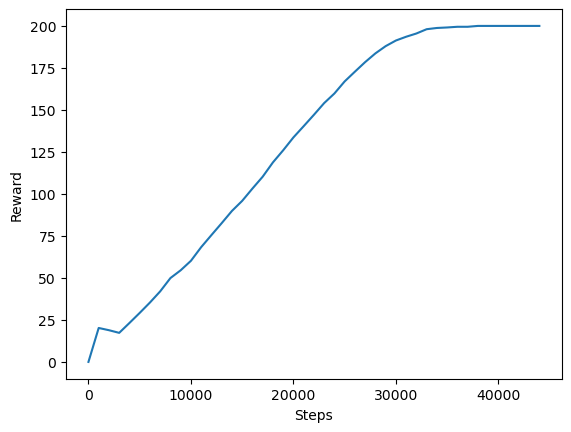

In [13]:
plt.plot(step_logging,reward_logging)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()


#### display
Video of preformance

In [21]:
# with network
from gym.wrappers import Monitor
from gym import wrappers


env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, "./results/networkCartPole", force=True)
obs = env.reset()

obs = env.reset()
eps_rew = 0.0
eps_rewards = []
for _ in range(10000):
    action = action_network.action(obs)
    
    obs, reward,done, _ = env.step(action)
    eps_rew += reward
    env.render()
    if done:
        eps_rewards.append(eps_rew)
        eps_rew = 0.0
        env.reset()


        
print("Average reward: ", np.mean(eps_rewards))

Exception ignored in: <function Monitor.__del__ at 0x000002599C9C9280>
Traceback (most recent call last):
  File "C:\Users\emanu\anaconda3\envs\dmlgpu\lib\site-packages\gym\wrappers\monitor.py", line 289, in __del__
    self.close()
  File "C:\Users\emanu\anaconda3\envs\dmlgpu\lib\site-packages\gym\wrappers\monitor.py", line 182, in close
    self.stats_recorder.close()
  File "C:\Users\emanu\anaconda3\envs\dmlgpu\lib\site-packages\gym\wrappers\monitoring\stats_recorder.py", line 105, in close
    self.flush()
  File "C:\Users\emanu\anaconda3\envs\dmlgpu\lib\site-packages\gym\wrappers\monitoring\stats_recorder.py", line 112, in flush
    with atomic_write.atomic_write(self.path) as f:
  File "C:\Users\emanu\anaconda3\envs\dmlgpu\lib\contextlib.py", line 119, in __enter__
    return next(self.gen)
  File "C:\Users\emanu\anaconda3\envs\dmlgpu\lib\site-packages\gym\utils\atomic_write.py", line 50, in atomic_write
    with open(tmppath, "wb" if binary else "w") as file:
FileNotFoundError: 

Average reward:  200.0


In [22]:
# random action
from gym.wrappers import Monitor
from gym import wrappers
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, "./results/randomCartPole", force=True)
obs = env.reset()
done = False
eps_rew = 0.0
eps_rewards = []
for _ in range(10000):
    action =  env.action_space.sample()
    obs, reward,done, _ = env.step(action)
    eps_rew += reward
    env.render()
    if done:
        eps_rewards.append(eps_rew)
        eps_rew = 0.0
        env.reset()
        
print("Average reward: ", np.mean(eps_rewards))

Average reward:  21.87308533916849


## TEST AREA

In [25]:
test_of_new = LinModel()
state_of_model = torch.load("./models/CartPoleLinear")
test_of_new.load_state_dict(state_of_model["model_state_dict"])
optimizer.load_state_dict(state_of_model['optimizer_state_dict'])

In [ ]:
# with network
from gym.wrappers import Monitor
from gym import wrappers


env = gym.make('CartPole-v0')
obs = env.reset()
eps_rew = 0.0
eps_rewards = []
for _ in range(10000):
    action = test_of_new.action(obs)
    obs, reward,done, _ = env.step(action)
    eps_rew += reward
    env.render()
    if done:
        eps_rewards.append(eps_rew)
        eps_rew = 0.0
        env.reset()